In [214]:
import json

def load_question_codes(question_codes_path):
    """Loads question codes and their numerical mappings."""
    with open(question_codes_path, 'r') as f:
        question_codes = json.load(f)
    
    # Create a mapping from question to options
    question_options_mapping = {}
    for entry in question_codes:
        question = entry['question']
        options = entry['options']
        # Reverse the options to map text -> number
        reversed_options = {v.lower(): k for k, v in options.items()}
        question_options_mapping[question] = reversed_options

    return question_options_mapping


In [225]:
import json

def map_responses_to_numerical_values(responses_path, question_codes_path, output_path):
    """Maps selected options in both before and after responses to their corresponding numerical values based on question codes."""
    
    # Load the question codes with their options
    question_options_mapping = load_question_codes(question_codes_path)

    # Read the entire file as one single JSON-like string
    with open(responses_path, 'r') as f:
        content = f.read()

    # Fix issues with trailing commas and extra characters
    content = content.replace('\n', '').replace('},}', '}}')  # Fix any trailing commas
    content = '[' + content.rstrip(',') + ']'  # Wrap the content into a list of JSON objects

    # Parse the entire content as JSON
    try:
        responses = json.loads(content)
    except json.JSONDecodeError as e:
        print(f"Error parsing the JSON file: {e}")
        return

    # Initialize a list to store the mapped responses
    mapped_responses = []

    def process_single_response(response):
        """Processes a single response and maps it to a numerical value."""
        if 'article_index' in response:
            # After-response
            question = response['question']
            selected_option = response.get('numerical_response') or response['response']['selected_option'].lower()
        else:
            # Before-response
            question_full = response['question']
            question = question_full.split('**Question**: ')[-1].split('\n')[0].strip()
            selected_option = response['response']['selected_option'].lower()

        # Handle 'n/a' case by assigning a default value
        if selected_option == 'n/a':
            numerical_value = 0  # Default value for 'n/a'
        elif question in question_options_mapping:
            options_mapping = question_options_mapping[question]

            # Map the selected option to a number
            if selected_option in options_mapping:
                numerical_value = options_mapping[selected_option]
            else:
                print(f"Warning: No match found for selected option '{selected_option}' in question '{question}'")
                return None
        else:
            print(f"Warning: Question '{question}' not found in question codes.")
            return None

        # Return the mapped response
        mapped_response = {
            "user_id": response['user_id'],
            "question": question,
            "numerical_response": numerical_value
        }

        if 'article_index' in response:
            mapped_response['article_index'] = response['article_index']
        
        return mapped_response

    # Iterate over the responses
    for response in responses:
        if isinstance(response, list):
            # If the response is a list, process each entry individually
            for item in response:
                mapped_response = process_single_response(item)
                if mapped_response:
                    mapped_responses.append(mapped_response)
        else:
            # Process as a single response
            mapped_response = process_single_response(response)
            if mapped_response:
                mapped_responses.append(mapped_response)

    # Save the mapped responses to the output file
    with open(output_path, 'w') as outfile:
        for mapped_response in mapped_responses:
            outfile.write(json.dumps(mapped_response) + '\n')

    print(f"Mapped responses saved to {output_path}")


In [226]:

map_responses_to_numerical_values('../data/processed/responses_after.json', '../data/raw/question_codes.json', '../data/processed/mapped_after_responses.json')


Mapped responses saved to ../data/processed/mapped_after_responses.json


In [ ]:
map_responses_to_numerical_values('../data/processed/responses.json', '../data/raw/question_codes.json', '../data/processed/mapped_before_responses.json')

Mapped responses saved to ../data/processed/mapped_before_responses.json


### General Opinion Changes Before vs After Exposure to Articles

In [ ]:
import pandas as pd
import json

def calculate_opinion_change(before_responses_path, after_responses_path):
    # Load the before and after responses
    with open(before_responses_path, 'r') as f:
        before_responses = [json.loads(line.strip()) for line in f.readlines()]

    with open(after_responses_path, 'r') as f:
        after_responses = [json.loads(line.strip()) for line in f.readlines()]

    # Convert to dictionaries for easier lookup
    before_dict = {(r['user_id'], r['question']): r['numerical_response'] for r in before_responses}
    after_dict = {(r['user_id'], r['question'], r['article_index']): r['numerical_response'] for r in after_responses}

    # Calculate opinion change for each user/question pair
    changes = []
    for (user_id, question), before_value in before_dict.items():
        # Get the after values for both left- and right-aligned articles
        after_left = after_dict.get((user_id, question, 0))
        after_right = after_dict.get((user_id, question, 1))

        if after_left and after_right:
            changes.append({
                "user_id": user_id,
                "question": question,
                "before": before_value,
                "after_left": after_left,
                "after_right": after_right,
                "change_left": int(after_left) - int(before_value),
                "change_right": int(after_right) - int(before_value)
            })

    return pd.DataFrame(changes)

# Example usage
changes_df = calculate_opinion_change('../data/processed/mapped_before_responses.json', '../data/processed/mapped_after_responses.json')
print(changes_df)


        user_id                                           question before  \
0    IDUS103408    I feel like I am treated fairly by politicians.      6   
1    IDUS103408  To what degree does this concern you: The situ...      2   
2    IDUS103408  To what degree does this concern you: The stat...      4   
3    IDUS103408  Agree or disagree: In the US, you can express ...      3   
4    IDUS103408  Agree or disagree: We no longer have room in t...      1   
..          ...                                                ...    ...   
813  IDUS140555  To what degree does this concern you: The stat...      5   
814  IDUS140555  Agree or disagree: In the US, you can express ...      6   
815  IDUS140555  Agree or disagree: We no longer have room in t...      7   
816  IDUS140555  Agree or disagree: Foreigners exacerbate crime...      7   
817  IDUS140555  Agree or disagree: Foreigners are taking jobs ...      7   

    after_left after_right  change_left  change_right  
0            5     

In [ ]:
changes_df.columns

Index(['user_id', 'question', 'before', 'after_left', 'after_right',
       'change_left', 'change_right'],
      dtype='object')

In [ ]:
# Calculate the mean change for left- and right-aligned articles
mean_change_left = changes_df['change_left'].mean()
mean_change_right = changes_df['change_right'].mean()

# Calculate the proportion of users whose opinion became more positive or negative
more_positive_left = (changes_df['change_left'] > 0).mean()
more_negative_left = (changes_df['change_left'] < 0).mean()

more_positive_right = (changes_df['change_right'] > 0).mean()
more_negative_right = (changes_df['change_right'] < 0).mean()

print(f"Mean change after left-aligned articles: {mean_change_left.round(3)}")
print(f"Mean change after right-aligned articles: {mean_change_right.round(3)}")
print(f"Proportion of more positive changes (left-aligned): {more_positive_left.round(3)}")
print(f"Proportion of more negative changes (left-aligned): {more_negative_left.round(3)}")
print(f"Proportion of more positive changes (right-aligned): {more_positive_right.round(3)}")
print(f"Proportion of more negative changes (right-aligned): {more_negative_right.round(3)}")


Mean change after left-aligned articles: -0.103
Mean change after right-aligned articles: -0.351
Proportion of more positive changes (left-aligned): 0.22
Proportion of more negative changes (left-aligned): 0.224
Proportion of more positive changes (right-aligned): 0.213
Proportion of more negative changes (right-aligned): 0.24


In [ ]:
# Function to categorize political position and merge "Extreme Left" and "Far Left" into "Left"
def categorize_political_position(political_position):
    political_position = political_position.lower()
    if 'left' in political_position:  # Merge both "Far Left" and "Extreme Left" into "Left"
        return 'left'
    elif 'right' in political_position:
        return 'right'
    else:
        return 'moderate'  # If needed in the future

# Load the demographic data and process the political position column
def load_and_merge_demographics(changes_df, demographic_data_path):
    # Load demographic data from the CSV
    demographic_data = pd.read_csv(demographic_data_path)

    # Process the political position column to categorize left, right, or moderate
    demographic_data['political_alignment'] = demographic_data['Where would you place your own political position?'].apply(categorize_political_position)

    # Select only the user_id and political alignment for merging
    demographic_data = demographic_data[['user', 'political_alignment']]
    demographic_data = demographic_data.rename(columns={'user': 'user_id'})  # Rename to match the changes_df

    # Merge the opinion change data with the demographic data
    merged_df = changes_df.merge(demographic_data, on='user_id')
    return merged_df

# Function to perform group analysis
def group_analysis_by_alignment(changes_df, demographic_data_path):
    # Merge the changes_df with the demographic data
    merged_df = load_and_merge_demographics(changes_df, demographic_data_path)

    # Separate participants into left- and right-leaning groups
    left_leaning = merged_df[merged_df['political_alignment'] == 'left']
    right_leaning = merged_df[merged_df['political_alignment'] == 'right']

    # Calculate mean opinion changes for each group
    mean_change_left_leaning = left_leaning[['change_left', 'change_right']].mean()
    mean_change_right_leaning = right_leaning[['change_left', 'change_right']].mean()

    print(f"Mean opinion change for left-leaning participants:\n{mean_change_left_leaning}")
    print(f"Mean opinion change for right-leaning participants:\n{mean_change_right_leaning}")


In [ ]:
print(merged_df.head())  #  Shows row by row if the agents got polarised or not

      user_id                                           question before  \
0  IDUS103408    I feel like I am treated fairly by politicians.      6   
1  IDUS103408  To what degree does this concern you: The situ...      2   
2  IDUS103408  To what degree does this concern you: The stat...      4   
3  IDUS103408  Agree or disagree: In the US, you can express ...      3   
4  IDUS103408  Agree or disagree: We no longer have room in t...      1   

  after_left after_right  change_left  change_right political_alignment  \
0          5           6           -1             0               right   
1          4           5            2             3               right   
2          1           5           -3             1               right   
3          1           7           -2             4               right   
4          1           1            0             0               right   

   polarized  
0      False  
1       True  
2       True  
3       True  
4      False  


In [ ]:

group_analysis_by_alignment(changes_df, '../data/processed/combined_data.csv')

Mean opinion change for left-leaning participants:
change_left     0.014620
change_right   -0.540936
dtype: float64
Mean opinion change for right-leaning participants:
change_left    -0.186975
change_right   -0.214286
dtype: float64


In [ ]:
import numpy as np

# Function to check polarization based on alignment
def check_polarization(row, alignment):
    if alignment == 'left':
        return row['change_left'] < 0  # Moving towards more extreme (lower) values for left-leaning participants
    elif alignment == 'right':
        return row['change_right'] > 0  # Moving towards more extreme (higher) values for right-leaning participants

# Apply polarization check for each participant
def polarization_analysis(merged_df):
    merged_df['polarized'] = merged_df.apply(
        lambda row: check_polarization(row, row['political_alignment']), axis=1
    )

    # Calculate the percentage of polarized participants
    polarization_stats = merged_df.groupby('political_alignment')['polarized'].mean()
    print(f"Proportion of polarized participants:\n{polarization_stats}")




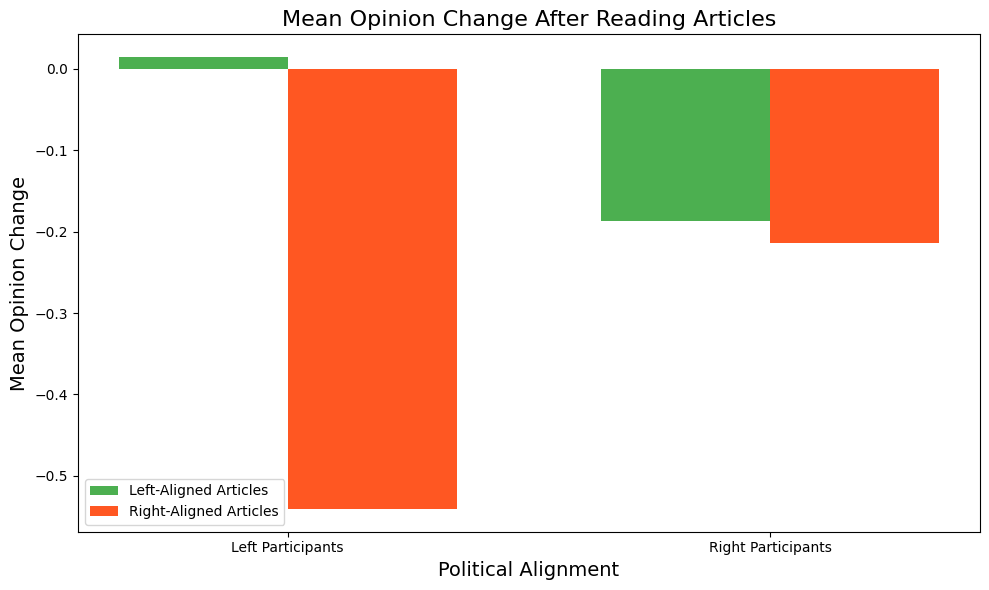

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create a bar plot for opinion changes with custom colors
def plot_opinion_changes(left_mean, right_mean):
    # Convert the Series to lists
    change_left = left_mean.values.tolist()
    change_right = right_mean.values.tolist()

    # Define the categories (Left and Right participants)
    categories = ['Left Participants', 'Right Participants']

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Plot bars with customized colors
    bar_width = 0.35
    index = np.arange(len(categories))

    # Bar plot with custom colors
    plt.bar(index, [change_left[0], change_right[0]], bar_width, label='Left-Aligned Articles', color='#4CAF50')  # Greenish color
    plt.bar(index + bar_width, [change_left[1], change_right[1]], bar_width, label='Right-Aligned Articles', color='#FF5722')  # Reddish color

    # Add labels and formatting
    plt.xlabel('Political Alignment', fontsize=14)
    plt.ylabel('Mean Opinion Change', fontsize=14)
    plt.title('Mean Opinion Change After Reading Articles', fontsize=16)
    plt.xticks(index + bar_width / 2, categories)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_opinion_changes(mean_change_left_leaning, mean_change_right_leaning)


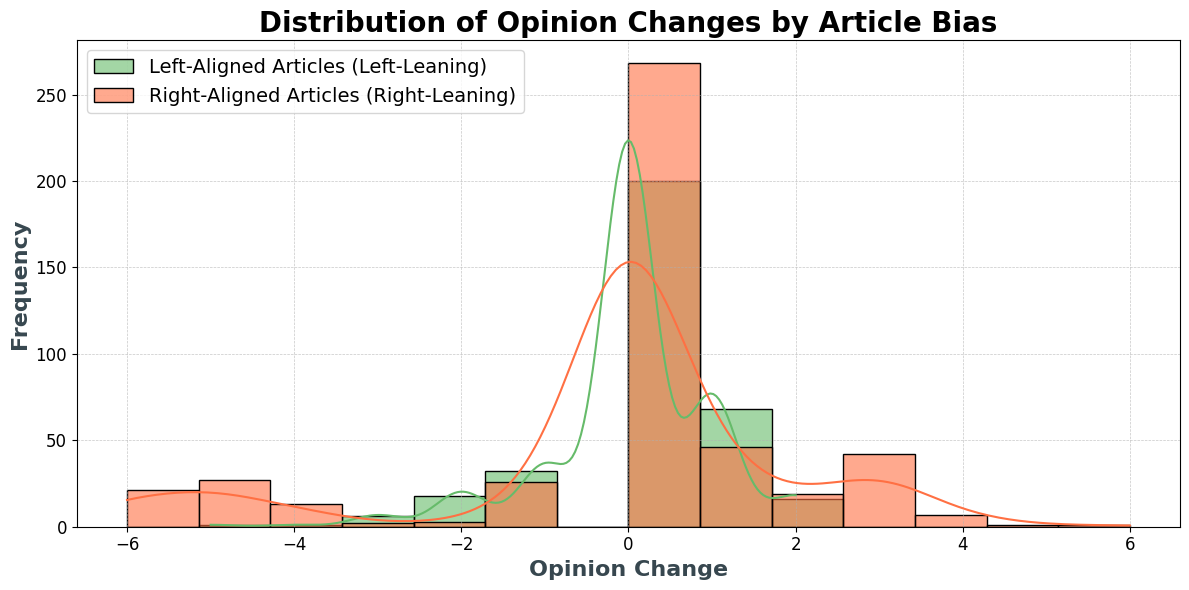

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot histogram with uniform bar widths
def plot_uniform_histogram_of_changes(merged_df):
    plt.figure(figsize=(12, 6))

    # Define a range of bins for both histograms
    bins = np.linspace(-6, 6, 15)  # 15 equally spaced bins from -6 to +6

    # Create histograms for left and right participants with the same bins
    sns.histplot(merged_df[merged_df['political_alignment'] == 'left']['change_left'], 
                 color='#66BB6A', label='Left-Aligned Articles (Left-Leaning)', kde=True, 
                 bins=bins, alpha=0.6)
    sns.histplot(merged_df[merged_df['political_alignment'] == 'right']['change_right'], 
                 color='#FF7043', label='Right-Aligned Articles (Right-Leaning)', kde=True, 
                 bins=bins, alpha=0.6)

    # Set axis labels and title with improved formatting
    plt.xlabel('Opinion Change', fontsize=16, weight='bold', color='#37474F')
    plt.ylabel('Frequency', fontsize=16, weight='bold', color='#37474F')
    plt.title('Distribution of Opinion Changes by Article Bias', fontsize=20, weight='bold')

    # Add a legend with a nicer location and gridlines for readability
    plt.legend(fontsize=14, loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Set the ticks for readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_uniform_histogram_of_changes(merged_df)


Resilience to Change: The strong peak at 0 suggests that a large portion of participants were resistant to opinion change after reading either left- or right-aligned articles. This could be due to confirmation bias, where participants hold on to their original beliefs even when exposed to new information.

Polarization: The negative shifts among right-leaning participants after reading right-aligned articles suggest that polarization occurred, with some individuals moving further away from their original opinions. This could indicate that right-aligned content was more effective at driving participants to more extreme positions (either in agreement or disagreement).

Left-Leaning Stability: Left-leaning participants seemed to be less affected by left-aligned articles in terms of extreme opinion shifts, which suggests that they were either already aligned with the content or less prone to extreme shifts.

In [ ]:
import pandas as pd

def filter_data():
    # Read the data from ../data/raw/overall_filtered_us_data.csv
    data = pd.read_csv('../data/raw/overall_filtered_us_data.csv', low_memory=False)

    # Read the user ids from ../data/processed/combined_data.csv
    user_ids = pd.read_csv('../data/processed/combined_data.csv')['user']

    # Filter the data to only include rows with user ids present in combined_data.csv
    data = data[data['unique_id'].isin(user_ids)]

    # Check for duplicate unique_id values before setting the index
    duplicate_ids = data['unique_id'].duplicated().sum()
    print(f"Number of duplicate unique_id values: {duplicate_ids}")

    # Option 1: Drop duplicate ids if duplicates exist
    if duplicate_ids > 0:
        data = data.drop_duplicates(subset='unique_id')

    # Read the question codes from ../data/raw/question_codes.json
    question_codes = pd.read_json('../data/raw/question_codes.json')['code']
    columns_to_keep = ['unique_id'] + list(question_codes)
    data = data[columns_to_keep]

    # Set unique_id as the index after handling duplicates
    data.set_index('unique_id', inplace=True)

    # Drop unnecessary columns
    data.drop(["F2A14",'F1A9_1', 'F1A13_1', 'F1A16_1', 'F2A8', 'F3A5_1'], axis=1, inplace=True)  # keep Index(['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1','F3A8_1'],


    return data

filtered_data = filter_data()

# Save the filtered data
filtered_data.to_csv('../data/processed/filtered_data.csv')


Number of duplicate unique_id values: 659


In [ ]:
# real people responses only for questions relevant to the study
filtered_data.head()
real_persona_df = filtered_data

### Plan
* Step 1: Align Before and After Responses
Input Data: We will need the responses from the LLM before and after exposure to articles.

Real-World Persona Comparison: Compare these responses to the real-world participants and compute a weighted difference and categorical accuracy.

Parse the responses from before and after article exposure.
Compute the weighted difference by comparing response vectors (likely numerical representations) between LLM and real-world personas.
Calculate categorical accuracy by measuring how often the LLM responses match real-world responses.
* Step 2: Analyze Article Bias Alignment
Input Data: Left-aligned and right-aligned articles.

Goal: Find out whether left-aligned or right-aligned articles better align LLM responses with real-world participants.

Analyze the impact of both left-aligned and right-aligned articles on LLM’s responses.
Compare which set of articles produces responses closer to real-world participants (potentially using the same metrics from Step 1).
* Step 3: Run Baseline Comparisons
Input Data: Random, average, and most frequent responses.

Goal: Compare the LLM performance to a random guess, average, and frequent responses.

Generate random responses, calculate the average response, and identify the most frequent responses.
Compare these with the LLM responses to assess the performance difference.

In [ ]:
import json
import re

# Step 1: Load the before responses
with open('../data/processed/responses.json', 'r', encoding="utf-8") as f:
    before_responses = json.load(f)

# Step 2: Load the question_code_map
with open('../data/raw/question_codes.json', 'r', encoding="utf-8") as f:
    question_code_map = json.load(f)

# Step 3: Create a mapping from question to code and options
question_code_mapping = {entry['question']: entry['code'] for entry in question_code_map}
code_options_mapping = {entry['code']: entry['options'] for entry in question_code_map}

# Step 4: Extract clean questions from before_responses
def extract_clean_question(prompt_text):
    # Regex to extract the actual question
    match = re.search(r"\*\*Question\*\*: (.*?)\n", prompt_text)
    if match:
        return match.group(1).strip()
    return None

# Step 5: Map the responses back to their code
mapped_responses = []

for response in before_responses:
    clean_question = extract_clean_question(response['question'])
    if clean_question and clean_question in question_code_mapping:
        code = question_code_mapping[clean_question]
        response_value = response['response']["selected_option"]  # Assuming 'response' holds the actual response

        # Check if response_value is a string
        if isinstance(response_value, str):
            # Convert the response to its corresponding numeric value
            options = code_options_mapping.get(code, {})
            response_code = None
            for key, option in options.items():
                if response_value.lower() == option.lower():
                    response_code = key
                    break
            
            # Append the mapped response with code and numeric response value
            mapped_responses.append({
                'unique_id': response['user_id'],
                'question_code': code,
                'response': response_value,
                'response_code': response_code
            })
        else:
            # Handle the case where response_value is not a string (log or inspect if needed)
            print(f"Unexpected response format: {response_value}")

# Step 6: Output the mapped responses
print(mapped_responses[:5])  # To verify the first few entries


[{'unique_id': 'IDUS103408', 'question_code': 'F1A9_1', 'response': 'Completely agree', 'response_code': '1'}, {'unique_id': 'IDUS103408', 'question_code': 'F1A10_1', 'response': 'Disagree', 'response_code': '6'}, {'unique_id': 'IDUS103408', 'question_code': 'F1A13_1', 'response': 'Disagree', 'response_code': '6'}, {'unique_id': 'IDUS103408', 'question_code': 'F1A16_1', 'response': 'Completely disagree', 'response_code': '7'}, {'unique_id': 'IDUS103408', 'question_code': 'F2A6', 'response': 'very concerned', 'response_code': '5'}]


In [ ]:
data_dict = {}

# Iterate over the mapped_responses to fill the data dictionary
for response in mapped_responses:
    unique_id = response['unique_id']
    question_code = response['question_code']
    response_code = response['response_code']
    
    # Initialize a dictionary for each unique_id if not already created
    if unique_id not in data_dict:
        data_dict[unique_id] = {}
    
    # Assign the response_code for each question_code
    data_dict[unique_id][question_code] = response_code

# Step 2: Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.reset_index(inplace=True)

# Rename the new index column to 'unique_id'
df.rename(columns={'index': 'unique_id'}, inplace=True)
df.drop(["F2A14",'F1A9_1', 'F1A13_1', 'F1A16_1', 'F2A8', 'F3A5_1'], axis=1, inplace=True)
df.set_index('unique_id', inplace=True)
df.head()

before_df = df

In [ ]:
### Same thing for after responses, but have 2 different dataframes depending on the article index (0 or 1). 0 is left, 1 is right aligned articles

In [ ]:
import json
import re
import pandas as pd

# Step 1: Load the after responses
with open('../data/processed/responses_after.json', 'r', encoding="utf-8") as f:
    after_responses = json.load(f)

# Step 2: Load the question_code_map
with open('../data/raw/question_codes.json', 'r', encoding="utf-8") as f:
    question_code_map = json.load(f)

# Step 3: Create a mapping from question to code and options
question_code_mapping = {entry['question']: entry['code'] for entry in question_code_map}
code_options_mapping = {entry['code']: entry['options'] for entry in question_code_map}

# Step 4: Extract clean questions from after_responses
def extract_clean_question(prompt_text):
    match = re.search(r"\*\*Question\*\*: (.*?)\n", prompt_text)
    if match:
        return match.group(1).strip()
    return None

# Step 5: Initialize separate lists for left and right aligned responses
left_mapped_responses = []
right_mapped_responses = []

for response in after_responses:
    clean_question = response['question']  # Assuming the questions in "responses_after.json" are already clean
    article_index = response['article_index']
    
    if clean_question and clean_question in question_code_mapping:
        code = question_code_mapping[clean_question]
        response_value = response['response']["selected_option"]

        # Check if response_value is a string
        if isinstance(response_value, str):
            # Convert the response to its corresponding numeric value
            options = code_options_mapping.get(code, {})
            response_code = None
            for key, option in options.items():
                if response_value.lower() == option.lower():
                    response_code = key
                    break

            # Separate responses into left or right aligned based on the article_index
            mapped_response = {
                'unique_id': response['user_id'],
                'question_code': code,
                'response': response_value,
                'response_code': response_code
            }
            
            if article_index == 0:
                left_mapped_responses.append(mapped_response)
            elif article_index == 1:
                right_mapped_responses.append(mapped_response)

# Step 6: Create data dictionaries for left and right responses
left_data_dict = {}
right_data_dict = {}

# Iterate over the left mapped_responses to fill the left data dictionary
for response in left_mapped_responses:
    unique_id = response['unique_id']
    question_code = response['question_code']
    response_code = response['response_code']
    
    if unique_id not in left_data_dict:
        left_data_dict[unique_id] = {}
    left_data_dict[unique_id][question_code] = response_code

# Iterate over the right mapped_responses to fill the right data dictionary
for response in right_mapped_responses:
    unique_id = response['unique_id']
    question_code = response['question_code']
    response_code = response['response_code']
    
    if unique_id not in right_data_dict:
        right_data_dict[unique_id] = {}
    right_data_dict[unique_id][question_code] = response_code

# Step 7: Convert the left and right dictionaries to DataFrames
left_df = pd.DataFrame.from_dict(left_data_dict, orient='index')
right_df = pd.DataFrame.from_dict(right_data_dict, orient='index')

# Step 8: Reset index and rename it to 'unique_id'
left_df.reset_index(inplace=True)
right_df.reset_index(inplace=True)

left_df.rename(columns={'index': 'unique_id'}, inplace=True)
right_df.rename(columns={'index': 'unique_id'}, inplace=True)

# Step 9: Drop unwanted columns (if necessary)
columns_to_drop = ["F2A14",'F1A9_1', 'F1A13_1', 'F1A16_1', 'F2A8', 'F3A5_1']
left_df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
right_df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

# Step 10: Set 'unique_id' as the index for both DataFrames
left_df.set_index('unique_id', inplace=True)
right_df.set_index('unique_id', inplace=True)

# Output the head of both DataFrames to verify
print(left_df.head())
print(right_df.head())


           F1A10_1 F2A7 F2A9 F3A3_1 F3A6_1 F3A7_1 F3A8_1
unique_id                                               
IDUS103408       5    4    1      1      1      1      1
IDUS103554       6    5    3      1      1      1      1
IDUS103826       7    5    2      3      1      1      1
IDUS104424       7    3    4      4      7      7      5
IDUS104578       6    5    2      1      1      1      1
           F1A10_1 F2A7 F2A9 F3A3_1 F3A6_1 F3A7_1 F3A8_1
unique_id                                               
IDUS103408       6    5    5      7      1      1      1
IDUS103554       1    2    5      7      1      1      1
IDUS103826       2    1    5      6      1      1      1
IDUS104424       7    2    1      5      7      1      7
IDUS104578       1    1    5      6      1      1      1


left_df and right_df refer to the bias of the articles

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Function to categorize the response based on question code
def categorize_response(response_code, question_code):
    if isinstance(question_code, str) and question_code.startswith("F2"):  # Concern-based questions
        if response_code in [1, 2]:  
            return 'Low Concern'
        elif response_code == 3:  
            return 'Moderate Concern'
        elif response_code in [4, 5]:  
            return 'High Concern'
    elif isinstance(question_code, str):  # Agree/Disagree scale questions
        if response_code in [1, 2]:  
            return 'Positive'
        elif response_code in [3, 4, 5]:  
            return 'Neutral'
        elif response_code in [6, 7]:  
            return 'Negative'
    return 'Unknown'

# Adapted function to evaluate alignment between DataFrames (LLM vs Real responses)
def evaluate_df_alignment(df, real_df, acceptable_difference_threshold=2):
    """
    Evaluates the alignment between left_df/right_df and real_persona_df using various metrics.
    
    Args:
    - df (pd.DataFrame): DataFrame (either left_df or right_df).
    - real_df (pd.DataFrame): DataFrame of real responses.
    - acceptable_difference_threshold (int): Threshold for "close enough" accuracy.
    
    Outputs a summary of metrics and their interpretation.
    """
    
    # Align the two DataFrames to ensure their indices and columns match
    df_aligned, real_df_aligned = df.align(real_df, join='inner', axis=0)

    # Stack the DataFrames to get user responses along with the question codes (from column names)
    comparison_df = pd.DataFrame({
        'response_code': df_aligned.stack(),
        'real_response_code': real_df_aligned.stack()
    }).reset_index()

    # The 'level_1' column in the stacked DataFrame contains the question codes (column names from original DataFrame)
    comparison_df.rename(columns={'level_1': 'question_code'}, inplace=True)
    
    # Ensure question_code is a string
    comparison_df['question_code'] = comparison_df['question_code'].astype(str)

    # Convert response_code and real_response_code to numeric
    comparison_df['response_code'] = pd.to_numeric(comparison_df['response_code'], errors='coerce')
    comparison_df['real_response_code'] = pd.to_numeric(comparison_df['real_response_code'], errors='coerce')

    # Drop rows with NaN in response_code or real_response_code
    comparison_df.dropna(subset=['response_code', 'real_response_code'], inplace=True)

    # Calculate the difference
    comparison_df['difference'] = np.abs(comparison_df['response_code'] - comparison_df['real_response_code'])
    
    # Exact Match Accuracy
    exact_match_accuracy = (comparison_df['response_code'] == comparison_df['real_response_code']).mean() * 100
    
    # "Close Enough" Accuracy
    close_enough_accuracy = (comparison_df['difference'] <= acceptable_difference_threshold).mean() * 100
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(comparison_df['real_response_code'], comparison_df['response_code'])
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(comparison_df['real_response_code'], comparison_df['response_code'])
    
    # Apply categorization based on question_code and response_code
    comparison_df['real_response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['real_response_code'], row['question_code']), axis=1)
    comparison_df['response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['response_code'], row['question_code']), axis=1)
    
    # Categorical Accuracy
    categorical_accuracy = (comparison_df['real_response_category'] == comparison_df['response_category']).mean() * 100
    
    # Print the metrics with interpretations
    print("---- DF Alignment Evaluation ----")
    print(f"Exact Match Accuracy: {exact_match_accuracy:.2f}%")
    print("Interpretation: The responses exactly match real people's responses.")
    
    print(f"'Close Enough' Accuracy (within {acceptable_difference_threshold} steps): {close_enough_accuracy:.2f}%")
    print("Interpretation: The responses are close to real people's responses within the threshold.")
    
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print("Interpretation: A high MSE indicates some large mismatches between responses.")
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Interpretation: On average, responses are about {mae:.2f} steps away from real people's responses.")
    
    print(f"Categorical Accuracy: {categorical_accuracy:.2f}%")
    print("Interpretation: The general sentiment or concern level matches this percentage of the time.")
    print("-----------------------------------")

# Example usage with left_df and real_persona_df
evaluate_df_alignment(left_df_filtered, real_persona_df_filtered)


---- DF Alignment Evaluation ----
Exact Match Accuracy: 22.47%
Interpretation: The responses exactly match real people's responses.
'Close Enough' Accuracy (within 2 steps): 64.10%
Interpretation: The responses are close to real people's responses within the threshold.
Mean Squared Error (MSE): 6.83
Interpretation: A high MSE indicates some large mismatches between responses.
Mean Absolute Error (MAE): 2.01
Interpretation: On average, responses are about 2.01 steps away from real people's responses.
Categorical Accuracy: 39.07%
Interpretation: The general sentiment or concern level matches this percentage of the time.
-----------------------------------


In [ ]:
# compare the left people in the persona dataframe with the left people in the left dataframe and see if the accuracy is higher.

0
0
0


### Does Polarized = Better Aligned?

In [ ]:
# Load the combined dataset to identify political positions
combined_df = pd.read_csv('../data/processed/combined_data.csv', )



In [ ]:
# Filter users who identify as "Far Left" or "Extreme Left"
left_users = combined_df[combined_df["Where would you place your own political position?"].isin(["Far Left", "Extreme Left"])]

# Get the list of user IDs for those on the "Far Left" or "Extreme Left"
left_user_ids = left_users['user'].tolist()

# Check how many users are identified
print(f"Number of users identifying as 'Far Left' or 'Extreme Left': {len(left_user_ids)}")


Number of users identifying as 'Far Left' or 'Extreme Left': 49


In [ ]:
# Filter the left_df and real_persona_df for the selected users
left_df_far_left = left_df_filtered[left_df_filtered.index.isin(left_user_ids)]
real_persona_df_far_left = real_persona_df_filtered[real_persona_df_filtered.index.isin(left_user_ids)]

# Check the shapes after filtering
print(f"Filtered left_df shape: {left_df_far_left.shape}")
print(f"Filtered real_persona_df shape: {real_persona_df_far_left.shape}")


Filtered left_df shape: (49, 7)
Filtered real_persona_df shape: (49, 7)


In [ ]:


# Step 4: Re-evaluate the alignment accuracy
evaluate_df_alignment(left_df_far_left, real_persona_df_far_left)


---- DF Alignment Evaluation ----
Exact Match Accuracy: 21.87%
Interpretation: The responses exactly match real people's responses.
'Close Enough' Accuracy (within 2 steps): 64.72%
Interpretation: The responses are close to real people's responses within the threshold.
Mean Squared Error (MSE): 6.61
Interpretation: A high MSE indicates some large mismatches between responses.
Mean Absolute Error (MAE): 1.99
Interpretation: On average, responses are about 1.99 steps away from real people's responses.
Categorical Accuracy: 38.48%
Interpretation: The general sentiment or concern level matches this percentage of the time.
-----------------------------------


In [ ]:
# Right Users
# Filter users who identify as "Far Left" or "Extreme Left"
right_users = combined_df[combined_df["Where would you place your own political position?"].isin(["Extreme Right"])]

# Get the list of user IDs for those on the "Far Left" or "Extreme Left"
right_user_ids = right_users['user'].tolist()

# Check how many users are identified
print(f"Number of users identifying as 'Extreme Right': {len(right_user_ids)}")


Number of users identifying as 'Extreme Right': 68


In [ ]:
# Filter the left_df and real_persona_df for the selected users
right_df_far_right = right_df_filtered[right_df_filtered.index.isin(right_user_ids)]
real_persona_df_far_right = real_persona_df_filtered[real_persona_df_filtered.index.isin(right_user_ids)]

# Check the shapes after filtering
print(f"Filtered right_df shape: {right_df_far_right.shape}")
print(f"Filtered real_persona_df shape: {real_persona_df_far_right.shape}")


Filtered right_df shape: (68, 7)
Filtered real_persona_df shape: (68, 7)


In [ ]:
evaluate_df_alignment(right_df_far_right, real_persona_df_far_right)

---- DF Alignment Evaluation ----
Exact Match Accuracy: 23.74%
Interpretation: The responses exactly match real people's responses.
'Close Enough' Accuracy (within 2 steps): 64.29%
Interpretation: The responses are close to real people's responses within the threshold.
Mean Squared Error (MSE): 6.81
Interpretation: A high MSE indicates some large mismatches between responses.
Mean Absolute Error (MAE): 1.98
Interpretation: On average, responses are about 1.98 steps away from real people's responses.
Categorical Accuracy: 42.65%
Interpretation: The general sentiment or concern level matches this percentage of the time.
-----------------------------------
